## Set up

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [20]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [21]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [22]:
sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

In [23]:
predictor.set_image(image)

## Combing YOLOX (through mmdet)

### Import

In [1]:
from mmdet.apis import init_detector, inference_detector
import torch
import cv2
from torchvision.ops import nms

### Load YOLOX

In [3]:
categories = [
    {"id": 1, "name": "电流互感器"}, # TA
    {"id": 2, "name": "母线"}, # W
    {"id": 3, "name": "散热器"}, # SQR
    {"id": 4, "name": "电抗器"}, # L
    {"id": 5, "name": "避雷器"}, # FV
    {"id": 6, "name": "套管"}, # CM
    {"id": 7, "name": "电压互感器"}, # TV
    {"id": 8, "name": "断路器"}, # QF
    {"id": 9, "name": "电容器"}, # C
    {"id": 10, "name": "变压器"}, # T
    {"id": 11, "name": "绝缘子"}, # JYZ
    {"id": 12, "name": "隔离开关"}, # QS
]

# 从1开始，但标签从0开始，给label+1
names = ['None', "电流互感器", "母线", "散热器", "电抗器", "避雷器", "套管", "电压互感器", "断路器", "电容器", "变压器", "绝缘子", "隔离开关"]
english_names = ['None', "TA", "W", "SQR", "L", "FV", "CM", "TV", "QF", "C", "T", "JYZ", "QS"]
colors = [[1, 1, 1, 0.6],
          [30/255, 144/255, 255/255, 0.6],
          [21/255, 168/255, 72/255, 0.6],
          [21/255, 43/255, 168/255, 0.6],
          [72/255, 21/255, 168/255, 0.6],
          [146/255, 21/255, 168/255, 0.6],
          [168/255, 21/255, 43/255, 0.6],
          [168/255, 72/255, 21/255, 0.6],
          [168/255, 146/255, 21/255, 0.6],
          [116/255, 168/255, 21/255, 0.6],
          [57/255, 222/255, 27/255, 0.6],
          [101/255, 233/255, 78/255, 0.6],
          [210/255, 78/255, 233/255, 0.6]]

In [4]:

def calculate_iou(mask1, mask2):
    """
    Calculate Intersection over Union (IoU) for two binary masks.

    Parameters:
        mask1 (numpy.ndarray): The first binary mask.
        mask2 (numpy.ndarray): The second binary mask.

    Returns:
        float: The IoU score.
    """
    # Make sure the input masks have the same shape
    assert mask1.shape == mask2.shape, "Both masks must have the same shape."

    # Calculate the intersection and union of the masks
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)

    # Compute the IoU score
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score

In [5]:
def show_mask(mask, label, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array(colors[label])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [6]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [7]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [8]:
def show_box_detail(box, ax, label, score):
    import matplotlib.font_manager as font_manager
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='red', facecolor=(0, 0, 0, 0), lw=2))

    font_path = '/usr/share/fonts/truetype/arphic/uming.ttc'  # 替换为你的中文字体文件路径
    font_prop = font_manager.FontProperties(fname=font_path)

    ax.text(x0, y0 - 10, f"{label}: {score:.2f}", color='red', fontsize=26, fontproperties=font_prop)

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [10]:
def test_model():

    device = torch.device("cuda")
    print("CUDA visible devices: " + str(torch.cuda.device_count()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name(device)))

    # teacher_model_type = 'vit_b'
    # checkpoint = 'checkpoints/sam_vit_b_qkv.pth'
    # teacher_model = sam_model_registry[teacher_model_type](checkpoint=checkpoint)
    # teacher_model.to(device)
    # teacher_model.eval()

    # teacher_model_type = 'vit_p77'
    # checkpoint = 'checkpoints/SlimSAM-77-uniform.pth'
    # SlimSAM_model = sam_model_registry[teacher_model_type](checkpoint=checkpoint)
    # SlimSAM_model.to(device)
    # SlimSAM_model.eval()

    # model_path = "checkpoints/SlimSAM-50.pth"
    model_path = "checkpoints/vit_b_slim_step2_.pth"
    SlimSAM_model = torch.load(model_path)
    SlimSAM_model.image_encoder = SlimSAM_model.image_encoder.module
    SlimSAM_model.to(device)
    SlimSAM_model.eval()
    print("model_path:",model_path)

    def forward(self, x):
        x = self.patch_embed(x)
        if self.pos_embed is not None:
            x = x + self.pos_embed

        for blk in self.blocks:
            x,qkv_emb,mid_emb,x_emb = blk(x)

        x = self.neck(x.permute(0, 3, 1, 2))

        return x

    import types
    funcType = types.MethodType
    SlimSAM_model.image_encoder.forward = funcType(forward, SlimSAM_model.image_encoder)

    example_inputs = torch.randn(1, 3, 1024, 1024).to(device)
    ori_macs, ori_size = tp.utils.count_ops_and_params(SlimSAM_model.image_encoder, example_inputs)
    print("MACs(G):",ori_macs/1e9,"Params(M):",ori_size/1e6)


    mask_generator = SamAutomaticMaskGenerator(
        model=SlimSAM_model,
        points_per_side=32,
        pred_iou_thresh=0.88,
        stability_score_thresh=0.90,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100,  # Requires open-cv to run post-processing
    )

    config_file = '/home/howardlyh/media/code_backup/SlimSAM-master/self_x.py'
    checkpoint_file = '/home/howardlyh/media/code_backup/SlimSAM-master/checkpoints/epoch_300.pth'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    det_model = init_detector(config_file, checkpoint_file, device=device)

    predictor = SamPredictor(SlimSAM_model)
    from pathlib import Path
    with torch.no_grad():
        # test_path_root = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/jiawei/data/samples/validation/images/'
        # test_paths = Path(test_path_root).glob("*.jpg")
        test_paths = [
            # "data/train/sa_2313.jpg",
            # "data/train/sa_3198.jpg",
            # "data/train/sa_3624.jpg",
            # "data/train/sa_4260.jpg",
            # "data/train/sa_5881.jpg",
            # "data/train/sa_16.jpg",
            # "data/train/sa_117.jpg",
            # "data/train/sa_161.jpg",
            # "data/train/sa_208.jpg",
            "data/train/sa_509.jpg",
        ]
        for path in test_paths:
            path = str(path)
        # path = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/jiawei/data/samples/validation/images/sa_1730.jpg'

        # with open(path.replace('jpg', 'json'), 'r', encoding='utf-8', errors='ignore') as f:
        #     data = json.load(f)
        # print(path)
        # anno = data['annotations'][0]

            result = inference_detector(det_model, path)
            pred_instances = result.pred_instances
            # 获取边界框信息
            bboxes = pred_instances.bboxes
            # 获取类别标签信息
            labels = pred_instances.labels
            # 获取置信度信息
            scores = pred_instances.scores

            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            predictor.set_image(image)

            ################ Box Prompt ################
            # input_box = np.array([input_box[0],input_box[1],input_box[0]+input_box[2],input_box[1]+input_box[3]])
            bboxes = np.array(bboxes.cpu())
            labels = np.array(labels.cpu())
            det_scores = np.array(scores.cpu())

            plt.figure(figsize=(15,10))
            plt.imshow(image)

            for box, label, score in zip(bboxes, labels, det_scores):
                if score < 0.5:
                    continue
                masks, scores, logits = predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box = box,
                    multimask_output=False,
                )
                label += 1
                # mask = mask_utils.decode(anno["segmentation"])
                # our_masks = masks[0]
                # iou = calculate_iou(our_masks, mask)
                # print('IoU', iou)
                show_mask(masks, label, plt.gca())
                show_box_detail(box, plt.gca(), english_names[label], score)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig('visualization/demo_box_' + path.split('/')[-1])

In [11]:
config_file = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/self_x.py'
checkpoint_file = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
det_model = init_detector(config_file, checkpoint_file, device=device)

Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth


### Test YOLOX

Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth


/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/miniconda3/envs/torch23cuda121/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


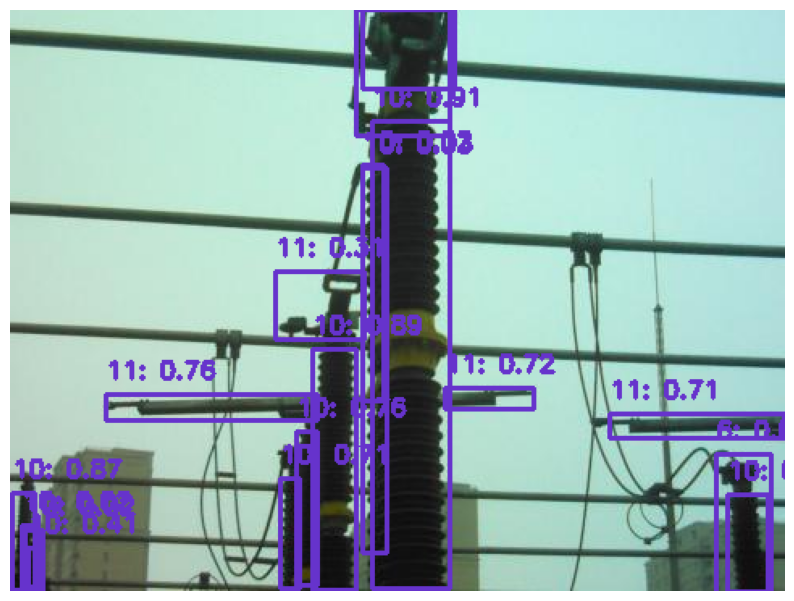

In [12]:
import torch
from mmdet.apis import init_detector, inference_detector
import cv2
import matplotlib.pyplot as plt

# 加载已训练的检测模型
config_file = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/self_x.py'
checkpoint_file = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = init_detector(config_file, checkpoint_file, device=device)

# 进行推理
image_path = 'sa_1.jpg'
result = inference_detector(model, image_path)

pred_instances = result.pred_instances

# 获取边界框信息
bboxes = pred_instances.bboxes
# 获取类别标签信息
labels = pred_instances.labels
# 获取置信度信息
scores = pred_instances.scores

# 加载原始图像 using OpenCV
# The image is now stored a NumPy array
image = cv2.imread(image_path)

# 绘制检测框
for bbox, label, score in zip(bboxes, labels, scores):
    x1, y1, x2, y2 = bbox
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (204, 51, 102), 2)
    label_text = f"{label}: {score:.2f}"
    cv2.putText(image, label_text, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (204, 51, 102), 2)

# # 保存可视化图片
# output_image_path = 'output_image.jpg'
# cv2.imwrite(output_image_path, image)


# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

Loads checkpoint by local backend from path: /media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth


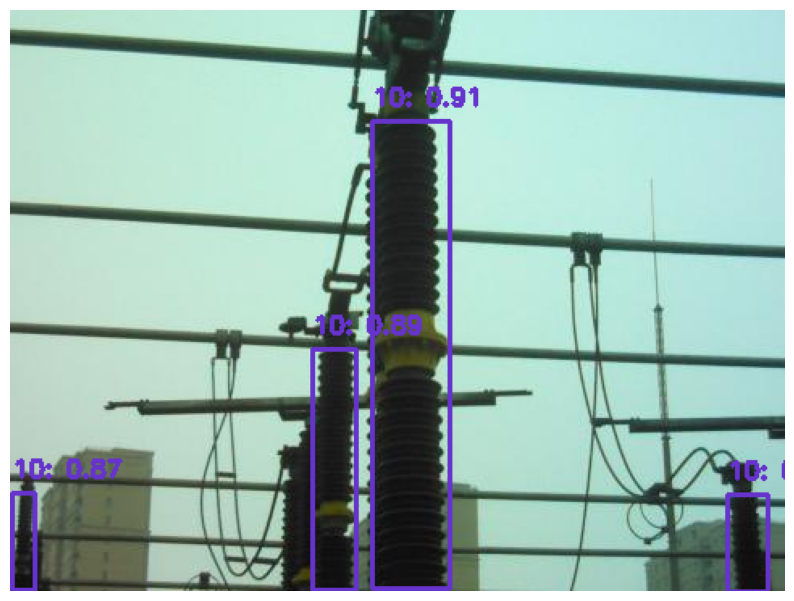

In [13]:
import torch
from mmdet.apis import init_detector, inference_detector
import cv2
import matplotlib.pyplot as plt

# Load the pre-trained detection model
config_file = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/self_x.py'
checkpoint_file = '/media/jiawei/11223d19-7ce9-4280-b00c-81bb984d9872/howardlyh/segment-anything-2-main/checkpoints/epoch_300.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = init_detector(config_file, checkpoint_file, device=device)

# Perform inference
image_path = 'sa_1.jpg'
result = inference_detector(model, image_path)

pred_instances = result.pred_instances

# Get bounding box, label, and score information
bboxes = pred_instances.bboxes
labels = pred_instances.labels
scores = pred_instances.scores

# Load the original image using OpenCV
# The image is now stored as a NumPy array
image = cv2.imread(image_path)

# Draw detection boxes, but only for scores greater than 0.8
for bbox, label, score in zip(bboxes, labels, scores):
    if score > 0.8:  # Only proceed if the score is greater than 0.8
        x1, y1, x2, y2 = bbox
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (204, 51, 102), 2)
        label_text = f"{label}: {score:.2f}"
        cv2.putText(image, label_text, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (204, 51, 102), 2)

# # Save the visualized image (optional)
# output_image_path = 'output_image.jpg'
# cv2.imwrite(output_image_path, image)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()


### Applying Box prompt with YOLOX

Use YOLOX model to detect objects and get the bounding boxes, scores, and labels:

In [15]:
image_path = './sa_1.jpg'  # Replace with your image path
results = inference_detector(det_model, image_path)

# Assuming results is a DataSample object
pred_instances = results.pred_instances  # Access the predicted instances

# Extracting bounding boxes and scores
bboxes = pred_instances.bboxes.cpu().numpy()  # Convert to numpy array for easier handling
scores = pred_instances.scores.cpu().numpy()  # Convert to numpy array for easier handling

# Now, bboxes and scores are numpy arrays that can be used with SAM2
print("Bounding boxes:\n", bboxes)
print("\n")

print("Scores:\n", scores)
print("\n")

# Extracting Labels
labels = pred_instances.labels.cpu().numpy()
print("Labels:\n", labels)
print("\n")

Bounding boxes:
 [[ 2.2475958e+02  6.9512016e+01  2.7271539e+02  3.5812628e+02]
 [ 1.8774605e+02  2.1093741e+02  2.1423953e+02  3.5994180e+02]
 [ 4.4471075e+02  3.0061057e+02  4.6941772e+02  3.6011774e+02]
 [ 1.3570526e+00  2.9976022e+02  1.5359954e+01  3.5918356e+02]
 [ 5.9872822e+01  2.3891653e+02  1.9081009e+02  2.5474944e+02]
 [ 1.7773672e+02  2.6116998e+02  1.9044286e+02  3.5643637e+02]
 [ 2.6919482e+02  2.3434448e+02  3.2478644e+02  2.4713559e+02]
 [ 1.6722446e+02  2.9062701e+02  1.7902899e+02  3.5826627e+02]
 [ 3.7131851e+02  2.5050618e+02  4.7977975e+02  2.6528040e+02]
 [ 2.1418359e+02 -2.9388142e-01  2.7279218e+02  7.8100189e+01]
 [ 1.1673418e+01  3.3385748e+02  2.0696749e+01  3.5916144e+02]
 [ 1.6409505e+02  1.6288326e+02  2.1942647e+02  2.0436339e+02]
 [ 2.1851520e+02  9.8540550e+01  2.3384854e+02  3.3666595e+02]
 [ 2.1810416e+02 -4.1633892e-01  2.7559662e+02  4.9677830e+01]
 [ 9.1281023e+00  3.2290454e+02  2.0013582e+01  3.5867923e+02]
 [ 2.1841417e+02  9.6524597e+01  2.313

In [25]:
import cv2

def refine_mask(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    refined_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return refined_mask

refined_masks = [refine_mask(mask) for mask in masks]


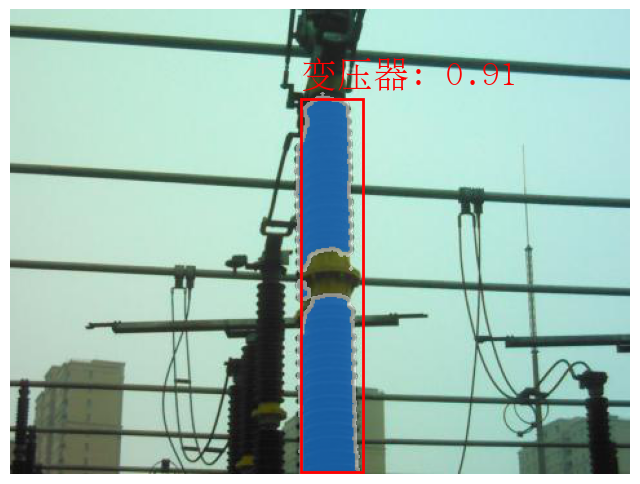

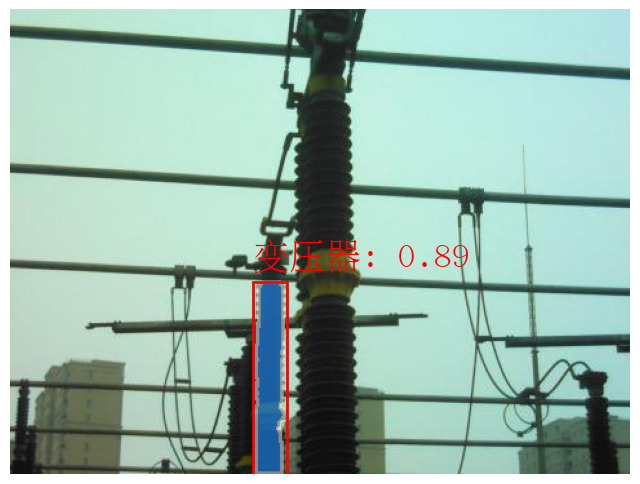

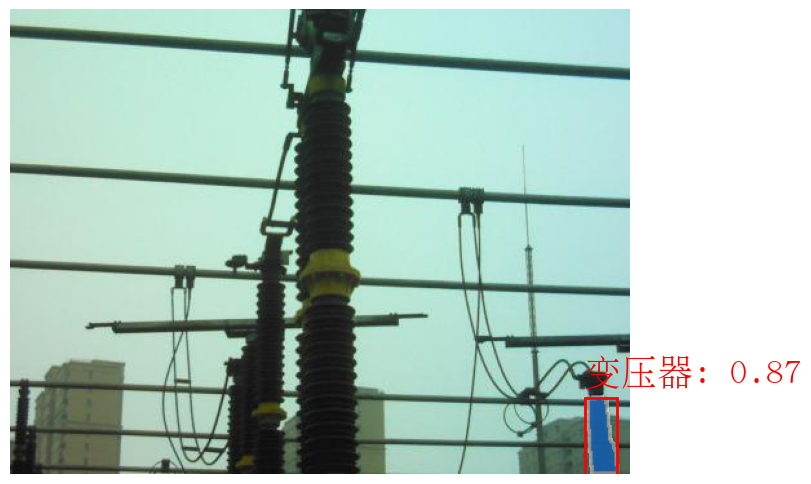

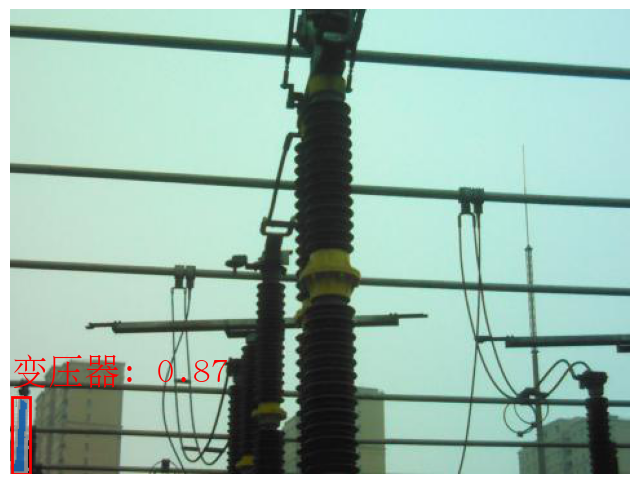

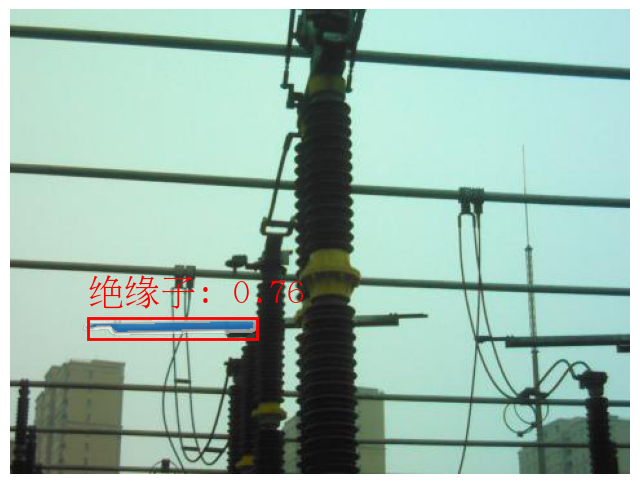

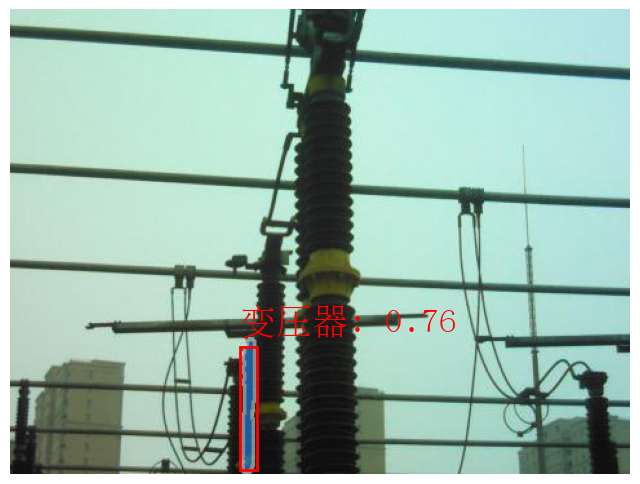

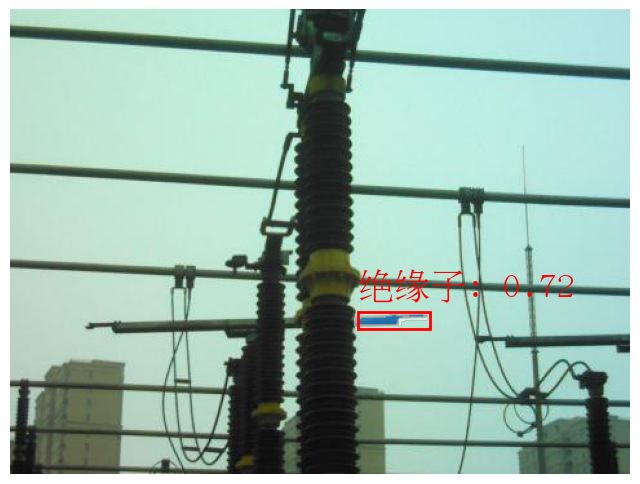

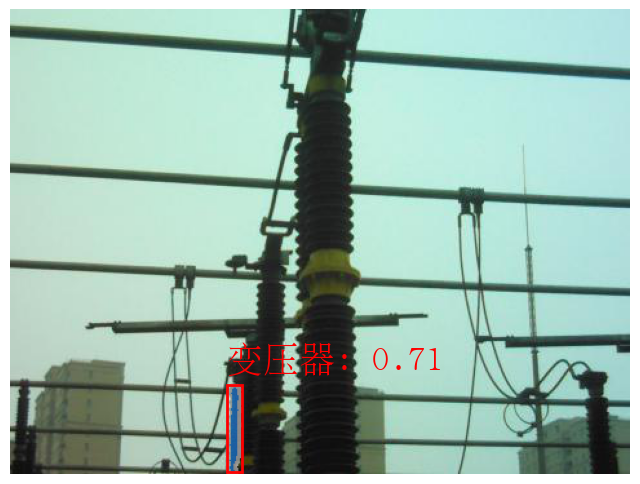

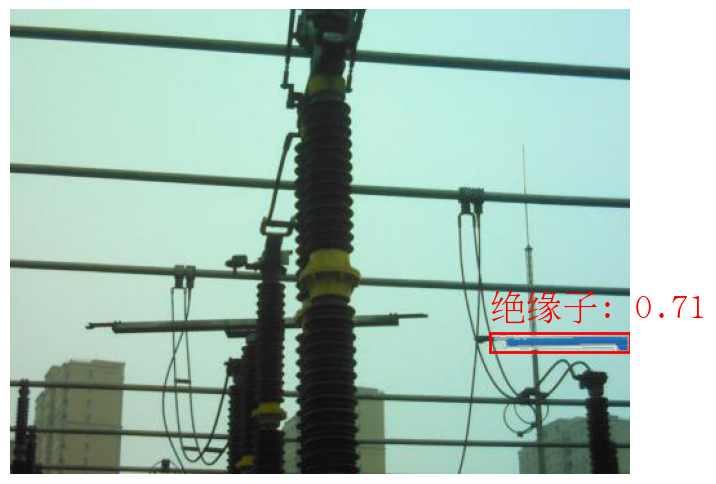

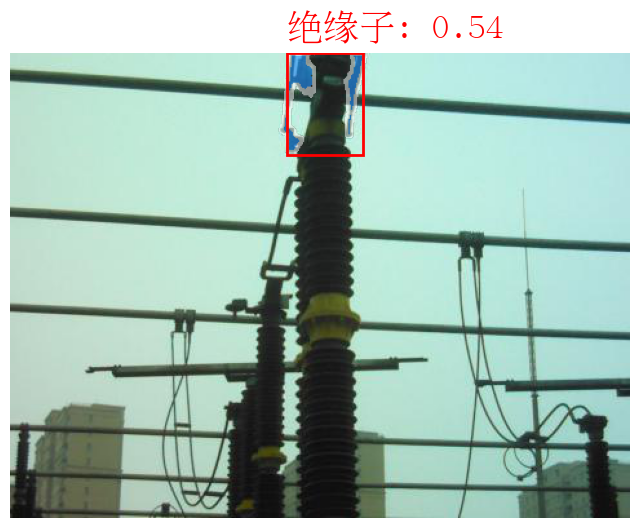

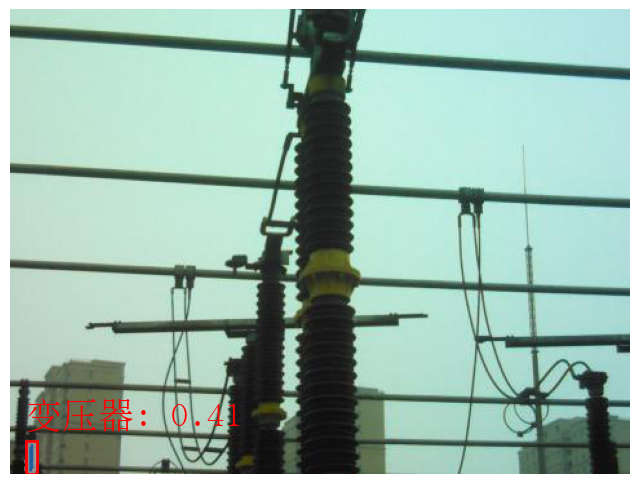

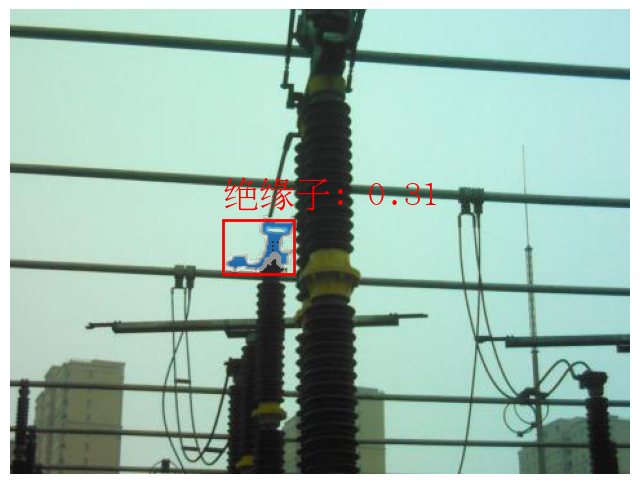

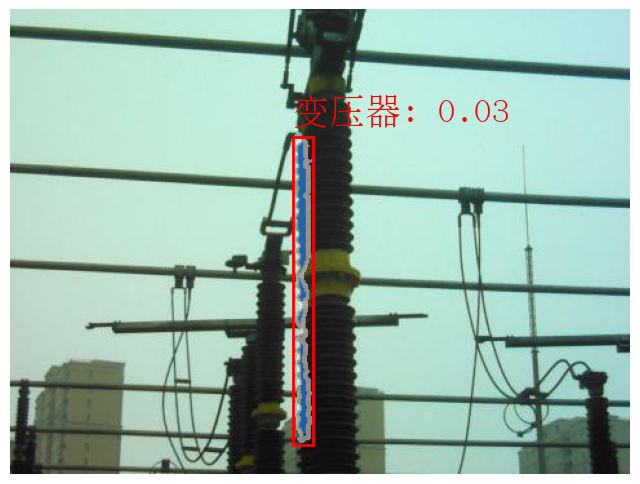

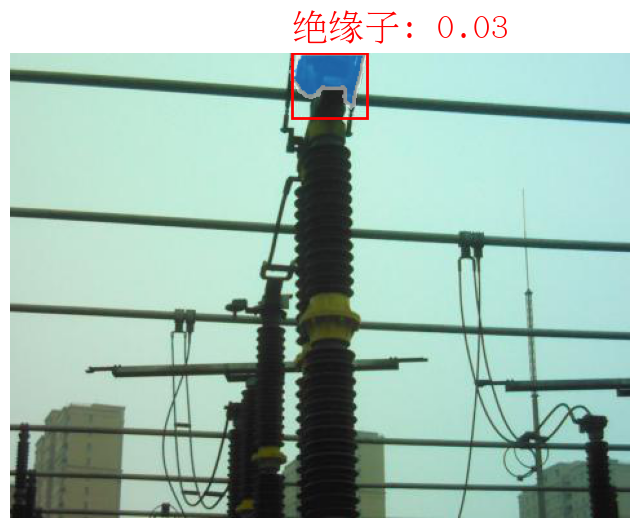

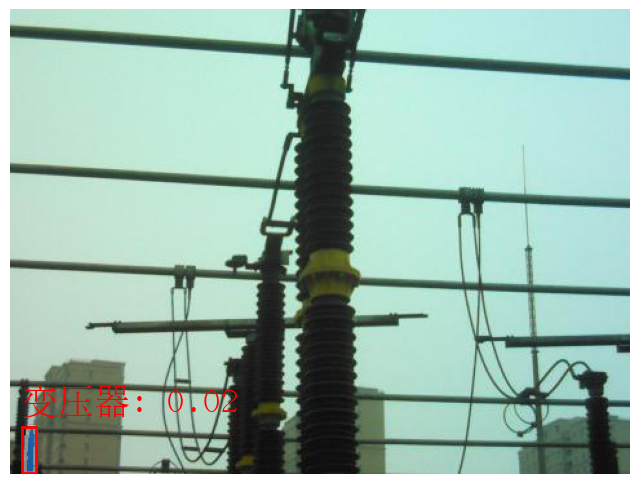

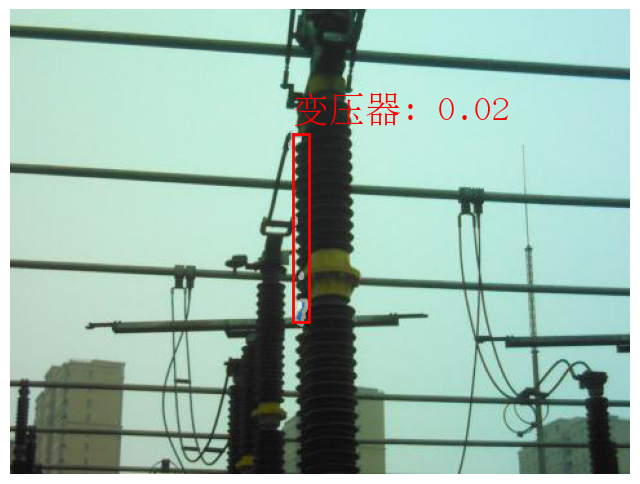

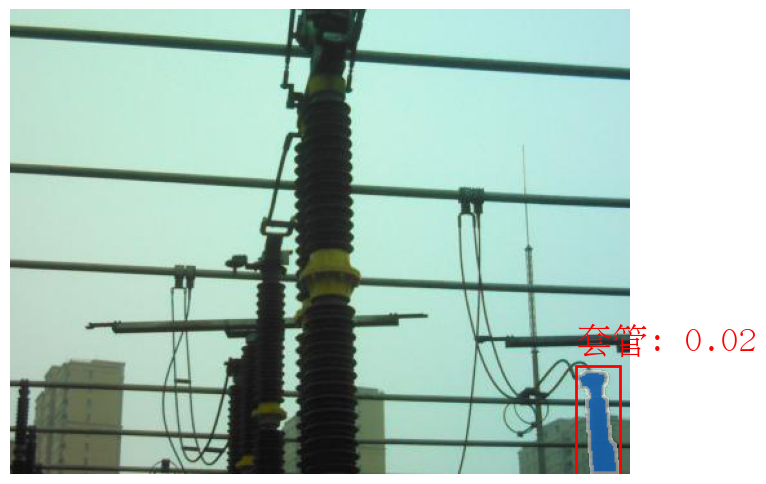

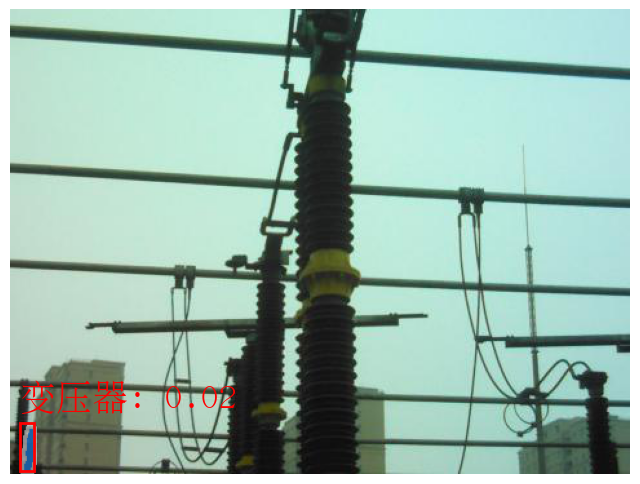

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and prepare the image
image = Image.open('./sa_1.jpg')
image = np.array(image.convert("RGB"))
predictor.set_image(image)

# Assume 'bboxes', 'labels', 'scores', and 'names' are already defined
for bbox, label, score in zip(bboxes, labels, scores):
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=bbox,
        multimask_output=False
    )

    # Convert mask to a single-channel format if it's not already
    mask = masks[0]
    if len(mask.shape) == 3:  # If the mask has multiple channels
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)

    # Refine masks
    refined_masks = [refine_mask(mask) for mask in masks]

    # Visualize or process the masks as needed
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    show_mask(mask, plt.gca())  # Pass only the mask and the axis
    show_box_detail(bbox, plt.gca(), names[label], score)
    plt.axis('off')
    plt.show()


#### 1) Filter by IoU score to keep only the most confident detections

In [30]:
# Filter by score 0.8

score_threshold = 0.8
valid_indices = scores > score_threshold
filtered_bboxes = bboxes[valid_indices]
filtered_scores = scores[valid_indices]

print("Filtered bounding boxes:", filtered_bboxes)
print("Filtered scores:", filtered_scores)
print("\n")

Filtered bounding boxes: [[224.75958    69.51202   272.7154    358.12628  ]
 [187.74605   210.93741   214.23953   359.9418   ]
 [444.71075   300.61057   469.41772   360.11774  ]
 [  1.3570526 299.76022    15.359954  359.18356  ]]
Filtered scores: [0.90979534 0.8888093  0.87431616 0.8663438 ]




#### 2) Eliminate overlapping bounding boxes with NMS

Apply NMS to eliminate overlapping bounding boxes that likely correspond to the same object. This step can help reduce multiple detections for the same object.

In [31]:
boxes_tensor = torch.tensor(filtered_bboxes)
scores_tensor = torch.tensor(filtered_scores)

keep_indices = nms(boxes_tensor, scores_tensor, iou_threshold=0.8)
refined_bboxes = filtered_bboxes[keep_indices]
refined_scores = filtered_scores[keep_indices]

print(refined_scores)
print("\n")

[0.90979534 0.8888093  0.87431616 0.8663438 ]




#### 3) Refining mask with Morphological Closing

In [32]:
def refine_mask(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    refined_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return refined_mask

#### 4) Testing on one image

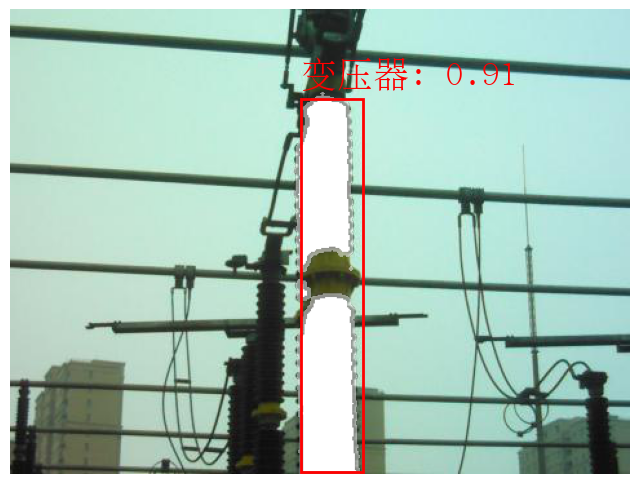

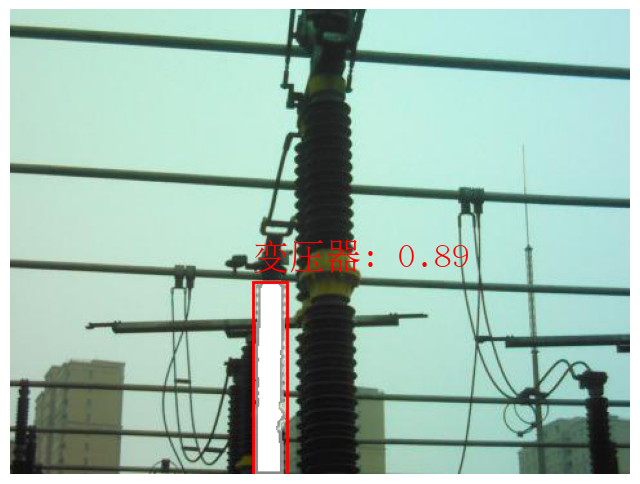

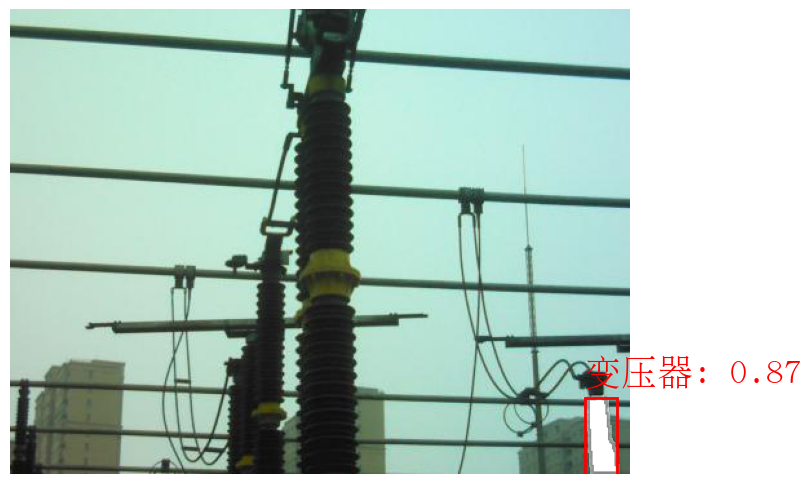

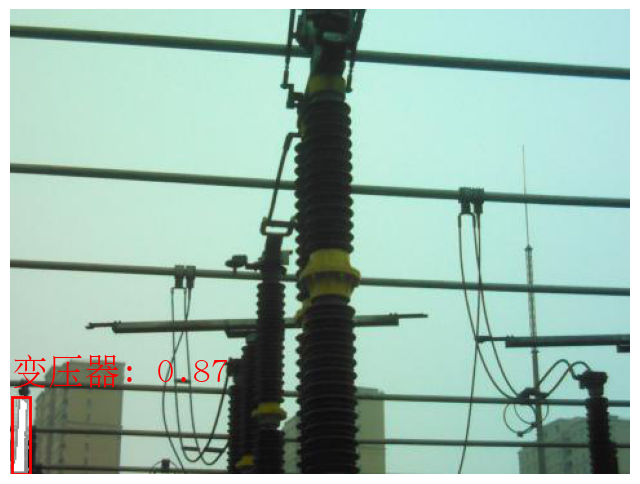

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and prepare the image
image = Image.open('./sa_1.jpg')
image = np.array(image.convert("RGB"))
predictor.set_image(image)

for bbox, label, score in zip(refined_bboxes, labels, refined_scores):
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=bbox,
        multimask_output=False
    )
    
    # Convert the mask to 8-bit single-channel format if necessary
    mask = masks[0]
    if len(mask.shape) == 3:  # If the mask has multiple channels
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    
    # Ensure mask is in the correct format for OpenCV
    mask = (mask * 255).astype(np.uint8)  # Scale and convert to 8-bit

    # Refine masks
    refined_masks = [refine_mask(mask) for mask in masks]
    
    # Visualize or process the masks as needed
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    show_mask(mask, plt.gca())  # Pass the axis object instead of an integer
    show_box_detail(bbox, plt.gca(), names[label], score)
    plt.axis('off')
    plt.show()


In [37]:
!nvidia-smi

Mon Aug 19 16:01:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:4B:00.0 Off |                  Off |
| 47%   36C    P8              21W / 450W |   6246MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--